In [1]:
pip install pandas scikit-learn datasets torch matplotlib seaborn transformers sentence_transformers nltk pymorphy2 tqdm ipywidgets catboost umap-learn hdbscan optuna category_encoders -q

Note: you may need to restart the kernel to use updated packages.


## 1. Анализ и подготовка данных

### 1.1. Импорт необходимых библиотек и моделей

In [2]:
import os
import math
import random
import json
import pickle
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, f1_score, roc_curve
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import LogisticRegression
import catboost as ctb

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import CatBoostEncoder

import re
import string
import nltk
import pymorphy2
from nltk.corpus import stopwords
nltk.download('stopwords')

import torch
import datasets
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
SEED = 42

def seed_torch(seed:int=42):
    """
    Функция для фиксации воспроизведения расчетов
        seed:int - параметр фиксации
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(SEED)

In [4]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Sat May 10 21:47:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             11W /  170W |     419MiB /  12288MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

In [5]:
model_gpt = AutoModelForCausalLM.from_pretrained("gpt2",
                                                 torch_dtype="auto",
                                                 trust_remote_code=True,
                                                 output_hidden_states=True
                                                 )
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2",
                                            trust_remote_code=True
                                            )

model_gpt = model_gpt.to(DEVICE)

In [6]:
model_phi = AutoModelForCausalLM.from_pretrained("microsoft/phi-1.5",
                                                 torch_dtype="auto",
                                                 trust_remote_code=True,
                                                 output_hidden_states=True
                                                 )
tokenizer_phi = AutoTokenizer.from_pretrained("microsoft/phi-1.5",
                                            trust_remote_code=True
                                            )

model_phi = model_phi.to(DEVICE)

In [7]:
embedding_model = SentenceTransformer("deepvk/USER-bge-m3")

embedding_model.to(DEVICE)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

### 1.2. Чтение Train / Test данных

In [8]:
ytrain_data = pd.read_csv('./data/ytrain.csv',
                          dtype={'dialog_id': str,
                                 'participant_index': str,
                                 'is_bot': str})
print(ytrain_data.shape)
ytrain_data.head()

(1572, 3)


,dialog_id,participant_index,is_bot
0,dae9e2dae9f840549764f8d9bbbb80f0,0,0
1,159da0d7937c4c1e84a51f0df7e3ade6,0,0
2,1aed86f082234446951360d00979f0d9,0,0
3,ab3dbd121828403ba30d0ed4008fbea4,0,0
4,08ce7e4224cc411ba629f1983eba031f,0,1


In [9]:
ytest_data = pd.read_csv('./data/ytest.csv',
                          dtype={'dialog_id': str,
                                 'participant_index': str,
                                 'is_bot': str})
print(ytest_data.shape)
ytest_data.head()

(676, 3)


,dialog_id,participant_index,ID
0,af36ac2aa9734738bbd533db8e5fb43a,0,af36ac2aa9734738bbd533db8e5fb43a_0
1,cdc2c5c605144c8e8dd5e9ea3d1352fc,0,cdc2c5c605144c8e8dd5e9ea3d1352fc_0
2,ed19efdedcb24600aea67c968aba5520,0,ed19efdedcb24600aea67c968aba5520_0
3,f2ea031960cf4454b4596d94cbee021e,0,f2ea031960cf4454b4596d94cbee021e_0
4,d948808cda4944cd838f88308a9ecd8b,0,d948808cda4944cd838f88308a9ecd8b_0


In [10]:
ytrain_data.nunique(), ytest_data.nunique()

(dialog_id            786
 participant_index      2
 is_bot                 2
 dtype: int64,
 dialog_id            338
 participant_index      2
 ID                   676
 dtype: int64)

In [11]:
with open("./data/train.json") as data:
    train = json.load(data)

parsed_data = []

for key, messages in train.items():
    for message in messages:
        # Добавляем каждое сообщение в список с дополнительным полем "conversation_id"
        parsed_data.append({
            'conversation_id': key,
            'message_index': message['message'],
            'text': message['text'],
            'participant_index': message['participant_index']
        })

train = pd.DataFrame(parsed_data)
print(train.shape)
train.head()

(6334, 4)


,conversation_id,message_index,text,participant_index
0,dae9e2dae9f840549764f8d9bbbb80f0,0,Hello!,0
1,dae9e2dae9f840549764f8d9bbbb80f0,1,Как дела?,1
2,dae9e2dae9f840549764f8d9bbbb80f0,2,Отлично! А твои?,0
3,dae9e2dae9f840549764f8d9bbbb80f0,3,Это круто!,1
4,dae9e2dae9f840549764f8d9bbbb80f0,4,Расскажи теорему,0


In [12]:
with open("./data/test.json") as data:
    test = json.load(data)

parsed_data = []

for key, messages in test.items():
    for message in messages:
        # Добавляем каждое сообщение в список с дополнительным полем "conversation_id"
        parsed_data.append({
            'conversation_id': key,
            'message_index': message['message'],
            'text': message['text'],
            'participant_index': message['participant_index']
        })

test = pd.DataFrame(parsed_data)
print(test.shape)
test.head()

(2955, 4)


,conversation_id,message_index,text,participant_index
0,af36ac2aa9734738bbd533db8e5fb43a,0,Привет,0
1,af36ac2aa9734738bbd533db8e5fb43a,1,кто ты?,1
2,af36ac2aa9734738bbd533db8e5fb43a,2,привет,0
3,af36ac2aa9734738bbd533db8e5fb43a,3,Я - виртуальный помощник,1
4,af36ac2aa9734738bbd533db8e5fb43a,4,ты бот?,0


In [13]:
train_data = (train.merge(ytrain_data,
                          how='left',
                          left_on=['conversation_id', 'participant_index'],
                          right_on=['dialog_id', 'participant_index']))

train_data['ID'] = train_data['conversation_id'] + '_' + train_data['participant_index']
train_data = train_data[['ID', 'message_index', 'text', 'is_bot']]
print(train_data.shape)
train_data.head()

(6334, 4)


,ID,message_index,text,is_bot
0,dae9e2dae9f840549764f8d9bbbb80f0_0,0,Hello!,0
1,dae9e2dae9f840549764f8d9bbbb80f0_1,1,Как дела?,0
2,dae9e2dae9f840549764f8d9bbbb80f0_0,2,Отлично! А твои?,0
3,dae9e2dae9f840549764f8d9bbbb80f0_1,3,Это круто!,0
4,dae9e2dae9f840549764f8d9bbbb80f0_0,4,Расскажи теорему,0


In [14]:
submission_data = (test.merge(ytest_data,
                               how='left',
                               left_on=['conversation_id', 'participant_index'],
                               right_on=['dialog_id', 'participant_index']))

submission_data = submission_data[['ID', 'message_index', 'text']]
print(submission_data.shape)
submission_data.head()

(2955, 3)


,ID,message_index,text
0,af36ac2aa9734738bbd533db8e5fb43a_0,0,Привет
1,af36ac2aa9734738bbd533db8e5fb43a_1,1,кто ты?
2,af36ac2aa9734738bbd533db8e5fb43a_0,2,привет
3,af36ac2aa9734738bbd533db8e5fb43a_1,3,Я - виртуальный помощник
4,af36ac2aa9734738bbd533db8e5fb43a_0,4,ты бот?


---
### 1.3. Подготовка данных для обучения
- Для моделей трансформеров gpt2 и phi приведем к нижнему регистру
- Для TfIdfVectorizer приведем к нижнему регистру, удалим спец символы, числа, стопслова и нормализуем оставшиеся токены

In [15]:
ENG_STOP_WORDS = list(set(stopwords.words('english')))
RUS_STOP_WORDS = list(set(stopwords.words('russian')))
STOP_WORDS = ENG_STOP_WORDS + RUS_STOP_WORDS
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer()
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()


def preprocess_text(text, stopwords: set=()):
    """
    Функция предобработки текста
        text - текст
        stopwords - стопслова
    """
    
    text = text.lower() # Приводим текст к нижнему регистру
    cleaned_text = re.sub(r"[^\w\s]", "", text, flags=re.UNICODE)  # Удаляем специальные символы
    cleaned_text = re.sub(r"[0-9]+", "", cleaned_text)            # Удаляем числа
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()      # Убираем лишние пробелы

    tokens = PUNCT_WORD_TOKENIZER.tokenize(cleaned_text)
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens]
    tokens_for_tfidf = [token for token in norm_tokens if token not in stopwords]
    text_for_tfidf = ' '.join(tokens_for_tfidf)

    return re.sub(r"\s+", " ", text).strip(), text_for_tfidf

In [16]:
train_data[['text_for_transformers', 'text_for_vectorizer']] = (train_data['text']
    .apply(lambda x: pd.Series(preprocess_text(text=x,
                                     stopwords=STOP_WORDS))
           )
)

In [17]:
train_data.head()

,ID,message_index,text,is_bot,text_for_transformers,text_for_vectorizer
0,dae9e2dae9f840549764f8d9bbbb80f0_0,0,Hello!,0,hello!,hello
1,dae9e2dae9f840549764f8d9bbbb80f0_1,1,Как дела?,0,как дела?,дело
2,dae9e2dae9f840549764f8d9bbbb80f0_0,2,Отлично! А твои?,0,отлично! а твои?,отлично твой
3,dae9e2dae9f840549764f8d9bbbb80f0_1,3,Это круто!,0,это круто!,это круто
4,dae9e2dae9f840549764f8d9bbbb80f0_0,4,Расскажи теорему,0,расскажи теорему,рассказать теорема


In [18]:
# Сортируем по ID и индексу сообщения
## Приводим текст по учатнику в список для расчета перплексии и производных
### Приводим предобработанный текст в строку для TfIdfVectorizer
#### Приводим текст в нижнем регистре для дальнейшей обработки эмбеддинг моделей

train_data = train_data.sort_values(by=['ID', 'message_index'])

def aggregate_group(group):
    text = group['text'].tolist()
    text_for_transformers = group['text_for_transformers'].tolist()
    text_for_vectorizer = ' '.join(group['text_for_vectorizer'].tolist())
    text_for_embeddings = ' '.join(group['text_for_transformers'].tolist())
    
    unique_is_bot = group['is_bot'].unique()
    if len(unique_is_bot) == 1:
        is_bot_value = unique_is_bot[0]
    else:
        is_bot_value = '-1'
    
    return pd.Series({
        'text': text,
        'text_for_transformers': text_for_transformers,
        'text_for_vectorizer': text_for_vectorizer,
        'text_for_embeddings': text_for_embeddings,
        'is_bot': is_bot_value
    })

result_train_df = train_data.groupby('ID').apply(aggregate_group).reset_index()
print(result_train_df.shape)
result_train_df.head()

(1572, 6)


,ID,text,text_for_transformers,text_for_vectorizer,text_for_embeddings,is_bot
0,000c0bd4f6554034ae2a050b5d8f6dea_0,"[че как?, жопа жопа/, жопич жопич]","[че как?, жопа жопа/, жопич жопич]",че жопа жопа жопич жопич,че как? жопа жопа/ жопич жопич,1
1,000c0bd4f6554034ae2a050b5d8f6dea_1,"[Жопка, жопич]","[жопка, жопич]",жопка жопич,жопка жопич,0
2,009952d565384a69b5ddf1ec76608391_0,"[чио рио?, да это отсылка, но почему именно на...","[чио рио?, да это отсылка, но почему именно на...",чио рио это отсылка почему именно это,"чио рио? да это отсылка, но почему именно на это",0
3,009952d565384a69b5ddf1ec76608391_1,"[""Чио Рио"" – это, вероятно, отсылка к популярн...","[""чио рио"" – это, вероятно, отсылка к популярн...",чио рио это вероятно отсылка популярный песня ...,"""чио рио"" – это, вероятно, отсылка к популярно...",1
4,00a66ccfbb7f42f39da2b641072d5ef6_0,"[I am OpenAI Assistant!, опенэйаю, ну то и имею]","[i am openai assistant!, опенэйаю, ну то и имею]",openai assistant опенэйать иметь,i am openai assistant! опенэйаю ну то и имею,0


In [19]:
# Формируем датасет

train_df = result_train_df.reset_index(drop=True).copy()
train_dataset = Dataset.from_pandas(train_df)

splits = {'train': train_dataset}

In [20]:
def calculate_perplexity(text, model, tokenizer, device):
        
    # Токенизация
    encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    encodings = {k: v.to(device) for k, v in encodings.items()}

    input_ids = encodings["input_ids"]
    with torch.no_grad():
        outputs = model(**encodings, labels=input_ids)
        neg_log_likelihood = outputs.loss.item()

    perplexity = math.exp(neg_log_likelihood)
    return perplexity

In [21]:
# Расчитываем перплексии двумя моделями gpt2 и phi

APPLY = True

if APPLY:
    perplexity_per_sample = defaultdict(list)
    
    for split in splits:
        for sample in tqdm(splits[split]):
            sample_id = sample["ID"]
            text = sample["text"]
            text_for_transformers = sample["text_for_transformers"]
            text_for_vectorizer = sample["text_for_vectorizer"]
            text_for_embeddings = sample["text_for_embeddings"]
            label = sample["is_bot"]

            cumulative_text = ""
            perplexities_gpt = []
            perplexities_phi = []
            for i in range(1, len(text_for_transformers) + 1):
                cumulative_text = ' '.join(text_for_transformers[:i])
                try:
                    ppl_gpt = calculate_perplexity(cumulative_text, model_gpt, tokenizer_gpt, DEVICE)
                    if np.isnan(ppl_gpt):
                        ppl_gpt = 0                
                    perplexities_gpt.append(ppl_gpt)
                except Exception as e:
                    print(f"Error processing sample ID {sample_id}: {e}")
                    perplexities_gpt.append(0)  # None при ошибке расчета перплексии
                    
                try:
                    ppl_phi = calculate_perplexity(cumulative_text, model_phi, tokenizer_phi, DEVICE)
                    if np.isnan(ppl_phi):
                        ppl_phi = 0                    
                    perplexities_phi.append(ppl_phi)
                except Exception as e:
                    print(f"Error processing sample ID {sample_id}: {e}")
                    perplexities_phi.append(0)  # None при ошибке расчета перплексии
        
            perplexity_per_sample[split].append({
                "ID": sample_id,
                "text": text,
                "text_for_transformers": text_for_transformers,
                "text_for_vectorizer": text_for_vectorizer,
                "text_for_embeddings": text_for_embeddings,
                "perplexities_gpt": perplexities_gpt,
                "perplexities_phi": perplexities_phi,
                "label": label
            })

    with open('./data/perplexity_per_sample.pkl', 'wb') as f:
        pickle.dump(perplexity_per_sample, f)
else:
    with open('./data/perplexity_per_sample.pkl', 'rb') as f:
        perplexity_per_sample = pickle.load(f)

 38%|██████████████████████████████▏                                                 | 593/1572 [01:33<03:19,  4.91it/s]

Error processing sample ID 5d722e49c3f544658f78a9c3d8abab58_1: cannot reshape tensor of 0 elements into shape [-1, 0] because the unspecified dimension size -1 can be any value and is ambiguous
Error processing sample ID 5d722e49c3f544658f78a9c3d8abab58_1: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)


 87%|████████████████████████████████████████████████████████████████████▍          | 1362/1572 [03:57<00:25,  8.19it/s]

Error processing sample ID dc815a924a094629af5ad9435eae071a_1: cannot reshape tensor of 0 elements into shape [-1, 0] because the unspecified dimension size -1 can be any value and is ambiguous
Error processing sample ID dc815a924a094629af5ad9435eae071a_1: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)


100%|███████████████████████████████████████████████████████████████████████████████| 1572/1572 [04:30<00:00,  5.82it/s]


In [22]:
def calculate_statistics(perplexities, name_model: str):
    
    mean_ppl = np.mean(perplexities)
    var_ppl = np.var(perplexities)
    min_ppl = np.min(perplexities)
    max_ppl = np.max(perplexities)
    
    return {f'mean_ppl_{name_model}': mean_ppl,
            f'var_ppl_{name_model}': var_ppl,
            f'min_ppl_{name_model}': min_ppl,
            f'max_ppl_{name_model}': max_ppl}

In [23]:
# Расчитываем производные от перплексии (mean, variance, min, max) по двум моделям gpt2 и phi
# Расчитываем среднюю перплексию от средних двух моделей

train_df = pd.DataFrame(perplexity_per_sample["train"])

train_df['cnt_ppl'] = train_df['text_for_transformers'].apply(len)

train_df['stats'] = train_df['perplexities_gpt'].apply(lambda x: calculate_statistics(x, 'gpt'))
train_df = train_df.join(pd.json_normalize(train_df['stats']))
train_df = train_df.drop(columns=['stats'])

train_df['stats'] = train_df['perplexities_phi'].apply(lambda x: calculate_statistics(x, 'phi'))
train_df = train_df.join(pd.json_normalize(train_df['stats']))
train_df = train_df.drop(columns=['stats'])

train_df['avg_ppl'] = ((train_df["mean_ppl_gpt"] + train_df["mean_ppl_phi"]) / 2)

print(train_df.shape)
train_df.head()

(1572, 18)


,ID,text,text_for_transformers,text_for_vectorizer,text_for_embeddings,perplexities_gpt,perplexities_phi,label,cnt_ppl,mean_ppl_gpt,var_ppl_gpt,min_ppl_gpt,max_ppl_gpt,mean_ppl_phi,var_ppl_phi,min_ppl_phi,max_ppl_phi,avg_ppl
0,000c0bd4f6554034ae2a050b5d8f6dea_0,"[че как?, жопа жопа/, жопич жопич]","[че как?, жопа жопа/, жопич жопич]",че жопа жопа жопич жопич,че как? жопа жопа/ жопич жопич,"[36.42694618834118, 28.71152507153782, 13.8200...","[17.519877373831033, 29.021882035975807, 12.91...",1,3,26.319518,8.803924e+01,13.820081,36.426946,19.819783,4.586949e+01,12.917590,29.021882,23.069650
1,000c0bd4f6554034ae2a050b5d8f6dea_1,"[Жопка, жопич]","[жопка, жопич]",жопка жопич,жопка жопич,"[46.47843969319909, 17.59653918886623]","[43.56504189319101, 23.452253603952332]",0,2,32.037489,2.085410e+02,17.596539,46.478440,33.508648,1.011311e+02,23.452254,43.565042,32.773069
2,009952d565384a69b5ddf1ec76608391_0,"[чио рио?, да это отсылка, но почему именно на...","[чио рио?, да это отсылка, но почему именно на...",чио рио это отсылка почему именно это,"чио рио? да это отсылка, но почему именно на это","[92.9852299114656, 10.196780458217356]","[196.09865195134788, 8.011710191756562]",0,2,51.591005,1.713482e+03,10.196780,92.985230,102.055181,8.844174e+03,8.011710,196.098652,76.823093
3,009952d565384a69b5ddf1ec76608391_1,"[""Чио Рио"" – это, вероятно, отсылка к популярн...","[""чио рио"" – это, вероятно, отсылка к популярн...",чио рио это вероятно отсылка популярный песня ...,"""чио рио"" – это, вероятно, отсылка к популярно...","[12.205685466212863, 7.7227875960294]","[7.35805482381056, 4.861050089003277]",1,2,9.964237,5.024093e+00,7.722788,12.205685,6.109552,1.558758e+00,4.861050,7.358055,8.036894
4,00a66ccfbb7f42f39da2b641072d5ef6_0,"[I am OpenAI Assistant!, опенэйаю, ну то и имею]","[i am openai assistant!, опенэйаю, ну то и имею]",openai assistant опенэйать иметь,i am openai assistant! опенэйаю ну то и имею,"[13369.948882653849, 162.6433695473659, 47.519...","[7109.670630495354, 273.96291856336404, 64.321...",0,3,4526.703998,3.910370e+07,47.519743,13369.948883,2482.651698,1.071198e+07,64.321546,7109.670630,3504.677848


In [24]:
# Подбираем порог и создаем столбец pred (будем использовать как прокси результат подбора порога в обучении)

perplexities = train_df['avg_ppl'].values
labels = train_df["label"].astype(int).values

thresholds = np.sort(perplexities)

best_threshold = None
best_f1 = 0

for threshold in thresholds:
    preds = (perplexities > threshold).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

train_df['pred'] = (train_df['avg_ppl'] > best_threshold).astype(int)
print(f"Best threshold: {best_threshold}, Train F1: {best_f1:.3f}")

Best threshold: 6.101101316674149, Train F1: 0.516


In [25]:
train_df["avg_ppl"].describe().astype(str)

count                1572.0
mean      6655.721666514063
std      58818.172503316426
min      1.0824072162655543
25%      10.463308196071335
50%      15.126838551727367
75%       34.59423616805846
max      1120591.4641129142
Name: avg_ppl, dtype: object

In [26]:
for i in [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    print(f"Для квантиля {i}, значение cредней перплексии = {np.round(train_df['avg_ppl'].quantile(i),2)}")

Для квантиля 0.5, значение cредней перплексии = 15.13
Для квантиля 0.6, значение cредней перплексии = 19.49
Для квантиля 0.65, значение cредней перплексии = 22.15
Для квантиля 0.7, значение cредней перплексии = 27.58
Для квантиля 0.75, значение cредней перплексии = 34.59
Для квантиля 0.8, значение cредней перплексии = 58.42
Для квантиля 0.85, значение cредней перплексии = 109.81
Для квантиля 0.9, значение cредней перплексии = 272.95
Для квантиля 0.95, значение cредней перплексии = 1097.46
Для квантиля 0.99, значение cредней перплексии = 300310.07


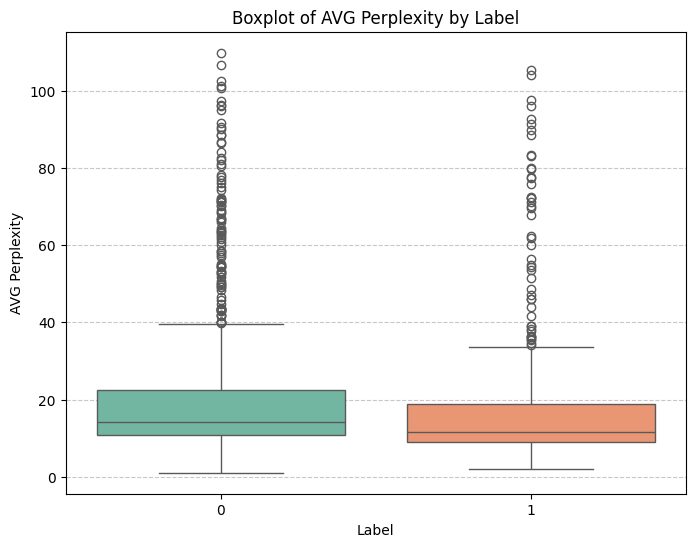

In [27]:
upper_bound = np.round(train_df['avg_ppl'].quantile(0.85),2)

df_label_0 = train_df[train_df['label'] == '0']['avg_ppl']
df_label_1 = train_df[train_df['label'] == '1']['avg_ppl']

# Фильтрация данных до 75% квантиля
df_label_0 = df_label_0[df_label_0 <= upper_bound]
df_label_1 = df_label_1[df_label_1 <= upper_bound]

boxplot_data = pd.DataFrame({
    'Label': ['0'] * len(df_label_0) + ['1'] * len(df_label_1),
    'AVG Perplexity': list(df_label_0) + list(df_label_1)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='AVG Perplexity', data=boxplot_data, palette='Set2')
plt.title('Boxplot of AVG Perplexity by Label')
plt.xlabel('Label')
plt.ylabel('AVG Perplexity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

* Видно что по порогу у человека среднее значение перплексии выше, чем у сгенерированного текста

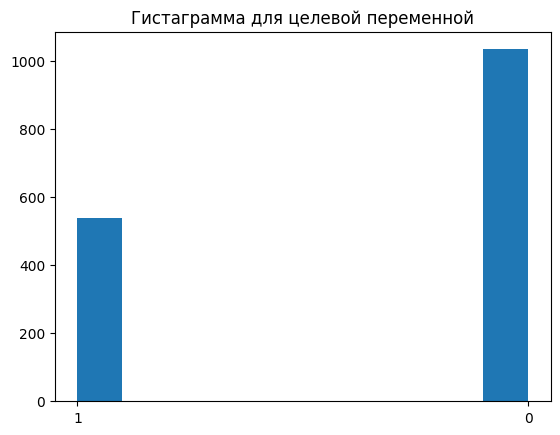

In [28]:
# Гистаграмма по целевой переменной

plt.hist(train_df['label'])
plt.title(f'Гистаграмма для целевой переменной')
plt.show()

---
### 1.4 Обработка числовых фичей
- Сделаем биннинг для средней перплексии по средним от двух моделей gpt2 и phi
- Для этой колонки обучим OHE
- Для колонки text_for_vectorizer обучим TfIdfVectorizer
- Для колонки text_for_embeddings применим эмбеддинг модель USER-bge-m3
- Для получившихся эмбеддингов после OHE и USER-bge-m3 подберем параметры для UMAP
- После подбора параметров снизим размерность эмбеддингов с помощью UMAP
- Также снизим размерность эмбеддингов OHE и USER-bge-m3 с помощью PCA до 50

In [29]:
train_df.columns

Index(['ID', 'text', 'text_for_transformers', 'text_for_vectorizer',
       'text_for_embeddings', 'perplexities_gpt', 'perplexities_phi', 'label',
       'cnt_ppl', 'mean_ppl_gpt', 'var_ppl_gpt', 'min_ppl_gpt', 'max_ppl_gpt',
       'mean_ppl_phi', 'var_ppl_phi', 'min_ppl_phi', 'max_ppl_phi', 'avg_ppl',
       'pred'],
      dtype='object')

In [30]:
num_bins = 10

train_df['binned'], bins = pd.qcut(train_df['avg_ppl'], q=num_bins, retbins=True)
bin_labels = [f"({bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(bins)-1)]

train_df['binned'] = pd.cut(train_df['avg_ppl'], bins=bins, labels=bin_labels, include_lowest=True)

num_cols = ['cnt_ppl', 'mean_ppl_gpt', 'var_ppl_gpt', 'min_ppl_gpt', 'max_ppl_gpt',
            'mean_ppl_phi', 'var_ppl_phi', 'min_ppl_phi', 'max_ppl_phi', 'avg_ppl']

scl = RobustScaler()
scl.fit(train_df[num_cols])

train_df[[f'{i}' for i in num_cols]] = scl.transform(train_df[num_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(train_df[['binned']])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['binned']))
train_df = pd.concat([train_df, encoded_train_df], axis=1)
print(train_df.shape)
train_df.head()

(1572, 30)


,ID,text,text_for_transformers,text_for_vectorizer,text_for_embeddings,perplexities_gpt,perplexities_phi,label,cnt_ppl,mean_ppl_gpt,...,"binned_(1.08, 8.34]","binned_(11.34, 12.77]","binned_(12.77, 15.13]","binned_(15.13, 19.49]","binned_(19.49, 27.58]","binned_(27.58, 58.42]","binned_(272.95, 1120591.46]","binned_(58.42, 272.95]","binned_(8.34, 9.78]","binned_(9.78, 11.34]"
0,000c0bd4f6554034ae2a050b5d8f6dea_0,"[че как?, жопа жопа/, жопич жопич]","[че как?, жопа жопа/, жопич жопич]",че жопа жопа жопич жопич,че как? жопа жопа/ жопич жопич,"[36.42694618834118, 28.71152507153782, 13.8200...","[17.519877373831033, 29.021882035975807, 12.91...",1,0.0,0.333180,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,000c0bd4f6554034ae2a050b5d8f6dea_1,"[Жопка, жопич]","[жопка, жопич]",жопка жопич,жопка жопич,"[46.47843969319909, 17.59653918886623]","[43.56504189319101, 23.452253603952332]",0,-0.5,0.555658,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,009952d565384a69b5ddf1ec76608391_0,"[чио рио?, да это отсылка, но почему именно на...","[чио рио?, да это отсылка, но почему именно на...",чио рио это отсылка почему именно это,"чио рио? да это отсылка, но почему именно на это","[92.9852299114656, 10.196780458217356]","[196.09865195134788, 8.011710191756562]",0,-0.5,1.316458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,009952d565384a69b5ddf1ec76608391_1,"[""Чио Рио"" – это, вероятно, отсылка к популярн...","[""чио рио"" – это, вероятно, отсылка к популярн...",чио рио это вероятно отсылка популярный песня ...,"""чио рио"" – это, вероятно, отсылка к популярно...","[12.205685466212863, 7.7227875960294]","[7.35805482381056, 4.861050089003277]",1,-0.5,-0.303182,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00a66ccfbb7f42f39da2b641072d5ef6_0,"[I am OpenAI Assistant!, опенэйаю, ну то и имею]","[i am openai assistant!, опенэйаю, ну то и имею]",openai assistant опенэйать иметь,i am openai assistant! опенэйаю ну то и имею,"[13369.948882653849, 162.6433695473659, 47.519...","[7109.670630495354, 273.96291856336404, 64.321...",0,0.0,175.436911,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
train_df.columns

Index(['ID', 'text', 'text_for_transformers', 'text_for_vectorizer',
       'text_for_embeddings', 'perplexities_gpt', 'perplexities_phi', 'label',
       'cnt_ppl', 'mean_ppl_gpt', 'var_ppl_gpt', 'min_ppl_gpt', 'max_ppl_gpt',
       'mean_ppl_phi', 'var_ppl_phi', 'min_ppl_phi', 'max_ppl_phi', 'avg_ppl',
       'pred', 'binned', 'binned_(1.08, 8.34]', 'binned_(11.34, 12.77]',
       'binned_(12.77, 15.13]', 'binned_(15.13, 19.49]',
       'binned_(19.49, 27.58]', 'binned_(27.58, 58.42]',
       'binned_(272.95, 1120591.46]', 'binned_(58.42, 272.95]',
       'binned_(8.34, 9.78]', 'binned_(9.78, 11.34]'],
      dtype='object')

In [32]:
ppl_factors = ['pred',
               'mean_ppl_gpt', 'var_ppl_gpt', 'min_ppl_gpt', 'max_ppl_gpt',
               'mean_ppl_phi', 'var_ppl_phi', 'min_ppl_phi', 'max_ppl_phi', 'avg_ppl',
               'binned_(1.08, 8.34]', 'binned_(11.34, 12.77]',
               'binned_(12.77, 15.13]', 'binned_(15.13, 19.49]',
               'binned_(19.49, 27.58]', 'binned_(27.58, 58.42]',
               'binned_(272.95, 1120591.46]', 'binned_(58.42, 272.95]',
               'binned_(8.34, 9.78]', 'binned_(9.78, 11.34]']

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             min_df=0.001
                            )

# Применение TF-IDF к текстовым данным
matrix = vectorizer.fit_transform(train_df['text_for_vectorizer'])
feature_names = vectorizer.get_feature_names_out()

need_score_df = (pd.DataFrame({'word': feature_names,
                               'score': matrix.toarray().sum(axis=0)})
                 .sort_values('score'))
print(need_score_df.shape)
need_score_df.head()

(3180, 2)


,word,score
737,бот ботм,0.025341
781,ботм ботт,0.025341
782,ботммт,0.025341
786,ботмт ботт,0.025341
780,ботм ботммт,0.025341


In [34]:
%%time

train_tfidf = vectorizer.transform(train_df['text_for_vectorizer'])
train_factors = train_df[ppl_factors].values
train_embeddings = embedding_model.encode(train_df['text_for_embeddings'].tolist())

print(f'TfIdf emb train: {train_tfidf.shape} shape')
print(f'PPL vectors train: {train_factors.shape} shape')
print(f'USER-bge-m3 emb train: {train_embeddings.shape} shape')

TfIdf emb train: (1572, 3180) shape
PPL vectors train: (1572, 20) shape
USER-bge-m3 emb train: (1572, 1024) shape
CPU times: user 3min 12s, sys: 421 ms, total: 3min 12s
Wall time: 3min 12s


In [35]:
all_train_embeddings = np.hstack([train_tfidf.toarray(), train_embeddings])

print(f'TfIdf + Robust scaler PPL + USER-bge-m3 emb train: {all_train_embeddings.shape} shape')

TfIdf + Robust scaler PPL + USER-bge-m3 emb train: (1572, 4204) shape


In [36]:
def evaluate_umap_logreg(
    train_embeddings: np.ndarray,
    y_train: np.ndarray,
    test_embeddings: np.ndarray,
    y_test: np.ndarray,
    n_neighbors: int,
    min_dist: float,
    n_components: int
) -> float:

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric='cosine',
        random_state=42,
        n_jobs=1
    )
    reduced_train_embeddings = umap_model.fit_transform(train_embeddings)
    reduced_test_embeddings = umap_model.transform(test_embeddings)

    logreg_model = LogisticRegression(penalty="l2", random_state=42)
    logreg_model.fit(reduced_train_embeddings, y_train)

    test_proba = logreg_model.predict_proba(reduced_test_embeddings)[:, 1]
    logloss = log_loss(y_test, test_proba)

    return logloss

def objective(trial: optuna.Trial,
              train_embeddings: np.ndarray,
              y_train: np.ndarray,
              test_embeddings: np.ndarray,
              y_test: np.ndarray) -> float:

    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_float('min_dist', 0.01, 0.5, log=True)
    n_components = trial.suggest_int('n_components', 5, 100)
    
    logloss = evaluate_umap_logreg(
        train_embeddings=train_embeddings,
        y_train=y_train,
        test_embeddings=test_embeddings,
        y_test=y_test,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components
    )
    return logloss

def run_cross_validation(embeddings: np.ndarray, y: np.ndarray, n_splits: int = 5, n_trials: int = 100):

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = {}
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(embeddings, y)):
        print(f"Обработка фолда {fold_idx + 1}/{n_splits}")
        
        train_embeddings = embeddings[train_idx]
        test_embeddings = embeddings[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction='minimize', sampler=sampler)
        study.optimize(lambda trial: objective(trial,
                                               train_embeddings,
                                               y_train,
                                               test_embeddings,
                                               y_test),
                       n_trials=n_trials,
                       show_progress_bar=True)

        best_params = study.best_params

        test_logreg = evaluate_umap_logreg(
            train_embeddings=train_embeddings,
            y_train=y_train,
            test_embeddings=test_embeddings,
            y_test=y_test,
            **best_params
        )

        fold_results[f'fold_{fold_idx + 1}'] = {'best_params': best_params,
                                                'test_logreg': test_logreg}

    mean_best_params = {}
    for param_name in fold_results['fold_1']['best_params'].keys():
        if param_name == 'min_dist':
            mean_best_params[param_name] = float(np.mean([fold['best_params'][param_name] for fold in fold_results.values()]))
        else:
            mean_best_params[param_name] = int(np.mean([fold['best_params'][param_name] for fold in fold_results.values()]))
    
    umap_parameters = ({'n_neighbors': mean_best_params['n_neighbors'],
                                           'min_dist': mean_best_params['min_dist'],
                                           'n_components': mean_best_params['n_components']})
        
    return fold_results, umap_parameters

In [37]:
UMAP_PARAMETERS = True

if UMAP_PARAMETERS: 
    fold_results, umap_parameters = run_cross_validation(all_train_embeddings,
                                                         train_df['label'],
                                                         n_splits=3,
                                                         n_trials=30)
else:
    fold_results, umap_parameters = ({'fold_1': {'best_params': {'n_neighbors': 44,
                                                                 'min_dist': 0.01235186974283217,
                                                                 'n_components': 68},
                                                 'test_logreg': 0.5635397850605937},
                                      'fold_2': {'best_params': {'n_neighbors': 29,
                                                                 'min_dist': 0.34830209280647606,
                                                                 'n_components': 67},
                                                 'test_logreg': 0.5451873304628118},
                                      'fold_3': {'best_params': {'n_neighbors': 36,
                                                                 'min_dist': 0.05102798314560107,
                                                                 'n_components': 31},
                                                 'test_logreg': 0.5423331865674791}},
                                     {'n_neighbors': 36, 'min_dist': 0.13722731523163642, 'n_components': 55})

[I 2025-05-10 21:55:43,401] A new study created in memory with name: no-name-2d3f7360-a6eb-44e2-bed0-f7f71fc4c389


Обработка фолда 1/3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-10 21:55:59,508] Trial 0 finished with value: 0.5735539721804284 and parameters: {'n_neighbors': 22, 'min_dist': 0.4123206532618726, 'n_components': 75}. Best is trial 0 with value: 0.5735539721804284.
[I 2025-05-10 21:56:07,359] Trial 1 finished with value: 0.564806740435984 and parameters: {'n_neighbors': 32, 'min_dist': 0.018410729205738687, 'n_components': 19}. Best is trial 1 with value: 0.564806740435984.
[I 2025-05-10 21:56:15,061] Trial 2 finished with value: 0.596088287353042 and parameters: {'n_neighbors': 7, 'min_dist': 0.29621516588303487, 'n_components': 62}. Best is trial 1 with value: 0.564806740435984.
[I 2025-05-10 21:56:24,477] Trial 3 finished with value: 0.5660398424340143 and parameters: {'n_neighbors': 37, 'min_dist': 0.01083858126934475, 'n_components': 98}. Best is trial 1 with value: 0.564806740435984.
[I 2025-05-10 21:56:32,736] Trial 4 finished with value: 0.5750336672300367 and parameters: {'n_neighbors': 43, 'min_dist': 0.022948683681130556, 'n_c

[I 2025-05-10 22:00:12,467] A new study created in memory with name: no-name-a2bb2b3e-e1be-4f5d-a1fa-7cf4fce3f417


Обработка фолда 2/3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-10 22:00:20,725] Trial 0 finished with value: 0.5462774751153524 and parameters: {'n_neighbors': 22, 'min_dist': 0.4123206532618726, 'n_components': 75}. Best is trial 0 with value: 0.5462774751153524.
[I 2025-05-10 22:00:28,502] Trial 1 finished with value: 0.5696511824093378 and parameters: {'n_neighbors': 32, 'min_dist': 0.018410729205738687, 'n_components': 19}. Best is trial 0 with value: 0.5462774751153524.
[I 2025-05-10 22:00:36,151] Trial 2 finished with value: 0.5984418363242487 and parameters: {'n_neighbors': 7, 'min_dist': 0.29621516588303487, 'n_components': 62}. Best is trial 0 with value: 0.5462774751153524.
[I 2025-05-10 22:00:45,288] Trial 3 finished with value: 0.572538072716254 and parameters: {'n_neighbors': 37, 'min_dist': 0.01083858126934475, 'n_components': 98}. Best is trial 0 with value: 0.5462774751153524.
[I 2025-05-10 22:00:53,841] Trial 4 finished with value: 0.575628183879641 and parameters: {'n_neighbors': 43, 'min_dist': 0.022948683681130556, '

[I 2025-05-10 22:04:36,620] A new study created in memory with name: no-name-e055df02-5863-4cd8-8f9a-e1124f0a9cb2


Обработка фолда 3/3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-10 22:04:45,125] Trial 0 finished with value: 0.5610772357314459 and parameters: {'n_neighbors': 22, 'min_dist': 0.4123206532618726, 'n_components': 75}. Best is trial 0 with value: 0.5610772357314459.
[I 2025-05-10 22:04:53,239] Trial 1 finished with value: 0.5556084552383337 and parameters: {'n_neighbors': 32, 'min_dist': 0.018410729205738687, 'n_components': 19}. Best is trial 1 with value: 0.5556084552383337.
[I 2025-05-10 22:05:01,002] Trial 2 finished with value: 0.6109269478624068 and parameters: {'n_neighbors': 7, 'min_dist': 0.29621516588303487, 'n_components': 62}. Best is trial 1 with value: 0.5556084552383337.
[I 2025-05-10 22:05:09,920] Trial 3 finished with value: 0.5555286640820025 and parameters: {'n_neighbors': 37, 'min_dist': 0.01083858126934475, 'n_components': 98}. Best is trial 3 with value: 0.5555286640820025.
[I 2025-05-10 22:05:18,418] Trial 4 finished with value: 0.5518138264785257 and parameters: {'n_neighbors': 43, 'min_dist': 0.022948683681130556,

In [38]:
fold_results, umap_parameters

({'fold_1': {'best_params': {'n_neighbors': 44,
    'min_dist': 0.01235186974283217,
    'n_components': 68},
   'test_logreg': 0.5635397850605937},
  'fold_2': {'best_params': {'n_neighbors': 29,
    'min_dist': 0.34830209280647606,
    'n_components': 67},
   'test_logreg': 0.5451873304628118},
  'fold_3': {'best_params': {'n_neighbors': 36,
    'min_dist': 0.05102798314560107,
    'n_components': 31},
   'test_logreg': 0.5423331865674791}},
 {'n_neighbors': 36, 'min_dist': 0.13722731523163642, 'n_components': 55})

In [39]:
# Уменьшение размерности с помощью UMAP
umap_model = umap.UMAP(**umap_parameters,
                       metric='cosine',
                       random_state=42)
train_reduced_embeddings = umap_model.fit_transform(all_train_embeddings)
print(f'Размер UMAP эмбеддингов трейна: {train_reduced_embeddings.shape}')

Размер UMAP эмбеддингов трейна: (1572, 55)


In [40]:
pca_model = PCA(n_components=50)

train_decomposed_embeddings = pca_model.fit_transform(all_train_embeddings)
print(f'Размер PCA эмбеддингов трейна: {train_decomposed_embeddings.shape}')

Размер PCA эмбеддингов трейна: (1572, 50)


In [41]:
X_train = np.hstack([train_factors, train_reduced_embeddings, train_decomposed_embeddings])

print(f'Размер PPL factors + UMAP + PCA эмбеддингов трейна: {X_train.shape}')

Размер PPL factors + UMAP + PCA эмбеддингов трейна: (1572, 125)


## 2. Обучение

### 2.1. Кастомный класс для кросс-валидации с использованием CatBoost
- Можно отследить среднее количество итераций для финального использования

In [43]:
class CustomCatboostCV():
    def __init__(self, 
                 train: pd.DataFrame, 
                 target: np.ndarray, 
                 main_estimator: object, 
                 main_fit_params: dict):

        self.X_train = pd.DataFrame(train).copy()
        self.y_train = target.copy()
        
        self.main_estimator = main_estimator
        self.main_fit_params = main_fit_params
        
    def _get_metric(self, y_true, y_pred):
        
        result = log_loss(y_true, y_pred)
        
        return result

    def _calc_main_metric(self, X_train, X_test, y_train, y_test)-> dict:

        y_pred_train = self.main_estimator.predict(X_train)
        y_pred_test = self.main_estimator.predict(X_test)

        main_train = self._get_metric(y_true=y_train, y_pred=y_pred_train)
        main_valid = self._get_metric(y_true=y_test, y_pred=y_pred_test)

        dict_temp = {'main_train': main_train, 'main_valid': main_valid}
        
        return dict_temp

    def _model_fit(self, 
                   X_train: pd.DataFrame, 
                   y_train: pd.DataFrame, 
                   X_val=None, 
                   y_val=None):
        
        self.main_fit_params.update({'X':X_train, 
                                     'y':y_train, 
                                     'eval_set':(X_val, y_val)
                                    })

        # Обучаем модель на трейне
        self.main_estimator.fit(**self.main_fit_params)

        print('BEST ITERATION: ', self.main_estimator.get_best_iteration())
        best_iteration = self.main_estimator.get_best_iteration()
        evals = self.main_estimator.get_evals_result()
        

        # формируем предсказания для тестовой выборки
        x_test_predict = self.main_estimator.predict_proba(X_val)[:,1]
        main_metric = self._calc_main_metric(X_train = X_train, X_test=X_val, y_train=y_train, y_test=y_val)

        return best_iteration, evals, main_metric

    def model_fit_cv(self, strat):
        i=0
        
        self._test_group = []

        self._best_iters = []
        self._main_scores = {}

        # убрать X_train_global

        X_train_global = self.X_train.copy()
        y_train_global = self.y_train.copy()

        for (train_index, test_index) in tqdm(strat.split(X_train_global, y_train_global)):
            i+=1

            print(f'==================== Обучение {i} фолда! ====================')

            X_train, X_test = X_train_global.iloc[train_index],X_train_global.iloc[test_index]
            y_train, y_test = y_train_global.iloc[train_index],y_train_global.iloc[test_index]

            # модель с контролем переобучения на последнем фолде
            best_iter, evals, main_metric  = self._model_fit(X_train=X_train, 
                                                             y_train=y_train,
                                                             X_val=X_test, 
                                                             y_val=y_test)

            self._best_iters.append(best_iter)
            self._main_scores[f'scores_{i}'] = main_metric
            print()
            print(f"LogLoss на обучающей выборке: {main_metric['main_train']}")
            print(f"LogLoss на проверочной выборке: {main_metric['main_valid']}")
            print()
            
        val_metrics = []
        for i in range(1, len(self._main_scores)+1):
            val_metrics.append(self._main_scores[f'scores_{i}']['main_valid']) 
        self.mean_cv_scores = np.mean(val_metrics)
        print()
        print(f"Среднее значение LogLoss: {self.mean_cv_scores}")

In [44]:
# Стартовые параметры модели, обучения в кросс-валидации и стратегия стратификации

params = {'iterations':1500,
          'loss_function':'Logloss',
          'random_state':42,
          'eval_metric':'Logloss',
          'thread_count':-1
         }

fit_params = {'use_best_model':True,
              'early_stopping_rounds':150, 
              'verbose':0,
              'plot':False}

strat = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42)

### 2.2. Подбор гиперпараметров с контролем переобучения на кросс-валидации с помощью Optuna

In [46]:
%%time

CATB_PARAMETERS = True

def create_model(trial):
    
    param = {'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
             'iterations':1500,
             'loss_function':'Logloss',
             'random_state':42,
             'eval_metric':'Logloss',
             'thread_count':-1,
             'depth': trial.suggest_int('depth', 3, 9),
             'subsample':trial.suggest_loguniform('subsample', 0.6, 1.0),
             'colsample_bylevel':trial.suggest_loguniform('colsample_bylevel', 0.6, 1.0),
             'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 1.0)
            }
        
    fit_params = {'early_stopping_rounds':150, 
                  'verbose':0}

    # создаем экземпляр класса XGBClassifier
    catb_model = ctb.CatBoostClassifier(**param)

    model = CustomCatboostCV(
        main_estimator=catb_model, 
        main_fit_params=fit_params,
        
        train=X_train,
        target=train_df["label"])
    
    return model
    
def objective(trial):
    my_model = create_model(trial)
    my_model.model_fit_cv(strat=strat)
    return my_model.mean_cv_scores


if CATB_PARAMETERS:
    sampler = TPESampler(seed=42)
    
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=30)
    best_params = study.best_params
else:
    best_params = {'learning_rate': 0.02252850830050382,
                   'depth': 4,
                   'subsample': 0.6577131255420214,
                   'colsample_bylevel': 0.6556830301283886,
                   'l2_leaf_reg': 0.10298740863909549}

[I 2025-05-10 22:10:20,697] A new study created in memory with name: no-name-b090aa13-1ab7-42da-bb79-6ffa64b152f2
0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:11, 11.23s/it]

BEST ITERATION:  43

LogLoss на обучающей выборке: 1.1349623681687657
LogLoss на проверочной выборке: 9.010913347279288

==================== Обучение 2 фолда! ====================


2it [00:24, 12.14s/it]

BEST ITERATION:  68

LogLoss на обучающей выборке: 0.8942127749208456
LogLoss на проверочной выборке: 8.460628562712614

==================== Обучение 3 фолда! ====================


3it [00:36, 12.21s/it]
[I 2025-05-10 22:10:57,338] Trial 0 finished with value: 8.804556553066785 and parameters: {'learning_rate': 0.010253509690168494, 'depth': 9, 'subsample': 0.8720536237417198, 'colsample_bylevel': 0.8146346649119967, 'l2_leaf_reg': 1.77071686435378e-07}. Best is trial 0 with value: 8.804556553066785.


BEST ITERATION:  66

LogLoss на обучающей выборке: 0.8942127749208456
LogLoss на проверочной выборке: 8.942127749208453


Среднее значение LogLoss: 8.804556553066785


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.96s/it]

BEST ITERATION:  1499

LogLoss на обучающей выборке: 6.878559807083426
LogLoss на проверочной выборке: 8.116700572358443

==================== Обучение 2 фолда! ====================


2it [00:05,  2.97s/it]

BEST ITERATION:  1499

LogLoss на обучающей выборке: 6.809774209012592
LogLoss на проверочной выборке: 7.979129376216774

==================== Обучение 3 фолда! ====================


3it [00:08,  2.96s/it]
[I 2025-05-10 22:11:06,210] Trial 1 finished with value: 8.13962910504872 and parameters: {'learning_rate': 0.0026364803038431655, 'depth': 3, 'subsample': 0.9339235897314236, 'colsample_bylevel': 0.815657556757104, 'l2_leaf_reg': 0.004619347374377372}. Best is trial 1 with value: 8.13962910504872.


BEST ITERATION:  1499

LogLoss на обучающей выборке: 6.844167008048009
LogLoss на проверочной выборке: 8.323057366570945


Среднее значение LogLoss: 8.13962910504872


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:38, 38.81s/it]

BEST ITERATION:  557

LogLoss на обучающей выборке: 0.7910343778145942
LogLoss на проверочной выборке: 8.460628562712614

==================== Обучение 2 фолда! ====================


2it [01:21, 41.19s/it]

BEST ITERATION:  646

LogLoss на обучающей выборке: 0.8598199758854285
LogLoss на проверочной выборке: 8.391842964641782

==================== Обучение 3 фолда! ====================


3it [02:02, 40.94s/it]
[I 2025-05-10 22:13:09,041] Trial 2 finished with value: 8.368914431951502 and parameters: {'learning_rate': 0.001136467270001117, 'depth': 9, 'subsample': 0.9179681421265244, 'colsample_bylevel': 0.6687417180293094, 'l2_leaf_reg': 2.8483918709107956e-07}. Best is trial 1 with value: 8.13962910504872.


BEST ITERATION:  611

LogLoss на обучающей выборке: 0.8942127749208456
LogLoss на проверочной выборке: 8.25427176850011


Среднее значение LogLoss: 8.368914431951502


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:03,  3.81s/it]

BEST ITERATION:  1005

LogLoss на обучающей выборке: 3.680029496789633
LogLoss на проверочной выборке: 7.91034377814594

==================== Обучение 2 фолда! ====================


2it [00:08,  4.45s/it]

BEST ITERATION:  1475

LogLoss на обучающей выборке: 2.9577807170458734
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 3 фолда! ====================


3it [00:14,  4.67s/it]
[I 2025-05-10 22:13:23,050] Trial 3 finished with value: 7.956200843526496 and parameters: {'learning_rate': 0.0031261029103110596, 'depth': 5, 'subsample': 0.7844545901841157, 'colsample_bylevel': 0.7481311065835492, 'l2_leaf_reg': 2.1371407316372935e-06}. Best is trial 3 with value: 7.956200843526496.


BEST ITERATION:  1119

LogLoss на обучающей выборке: 3.680029496789633
LogLoss на проверочной выборке: 7.91034377814594


Среднее значение LogLoss: 7.956200843526496


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.39it/s]

BEST ITERATION:  133

LogLoss на обучающей выборке: 6.0875254292688314
LogLoss на проверочной выборке: 8.39184296464178

==================== Обучение 2 фолда! ====================


2it [00:01,  1.20it/s]

BEST ITERATION:  208

LogLoss на обучающей выборке: 4.780599065922981
LogLoss на проверочной выборке: 7.979129376216774

==================== Обучение 3 фолда! ====================


3it [00:02,  1.20it/s]
[I 2025-05-10 22:13:25,554] Trial 4 finished with value: 8.208414703119555 and parameters: {'learning_rate': 0.044809759182149515, 'depth': 3, 'subsample': 0.6965674483654352, 'colsample_bylevel': 0.7234827275619211, 'l2_leaf_reg': 4.452048365748842e-05}. Best is trial 3 with value: 7.956200843526496.


BEST ITERATION:  272

LogLoss на обучающей выборке: 3.920779090037553
LogLoss на проверочной выборке: 8.25427176850011


Среднее значение LogLoss: 8.208414703119555


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.87it/s]

BEST ITERATION:  25

LogLoss на обучающей выборке: 6.0875254292688314
LogLoss на проверочной выборке: 8.116700572358441

==================== Обучение 2 фолда! ====================


2it [00:01,  1.85it/s]

BEST ITERATION:  45

LogLoss на обучающей выборке: 4.574242271710478
LogLoss на проверочной выборке: 8.460628562712614

==================== Обучение 3 фолда! ====================


3it [00:01,  1.79it/s]
[I 2025-05-10 22:13:27,232] Trial 5 finished with value: 8.162557637738997 and parameters: {'learning_rate': 0.13157287601765633, 'depth': 4, 'subsample': 0.7802495332778758, 'colsample_bylevel': 0.8120404846670511, 'l2_leaf_reg': 2.3528990899815284e-08}. Best is trial 3 with value: 7.956200843526496.


BEST ITERATION:  51

LogLoss на обучающей выборке: 4.367885477497976
LogLoss на проверочной выборке: 7.91034377814594


Среднее значение LogLoss: 8.162557637738997


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.35it/s]

BEST ITERATION:  121

LogLoss на обучающей выборке: 5.330883850489656
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 2 фолда! ====================


2it [00:02,  1.10s/it]

BEST ITERATION:  311

LogLoss на обучающей выборке: 2.2011391382666963
LogLoss на проверочной выборке: 7.4288445916501

==================== Обучение 3 фолда! ====================


3it [00:03,  1.06s/it]
[I 2025-05-10 22:13:30,423] Trial 6 finished with value: 7.841558180075105 and parameters: {'learning_rate': 0.04362599362560559, 'depth': 4, 'subsample': 0.6202729826779961, 'colsample_bylevel': 0.974227356206172, 'l2_leaf_reg': 0.530953226900921}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  267

LogLoss на обучающей выборке: 2.7858167218687875
LogLoss на проверочной выборке: 8.047914974287607


Среднее значение LogLoss: 7.841558180075105


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.70it/s]

BEST ITERATION:  12

LogLoss на обучающей выборке: 6.534631816729254
LogLoss на проверочной выборке: 9.21727014149179

==================== Обучение 2 фолда! ====================


2it [00:01,  1.56it/s]

BEST ITERATION:  10

LogLoss на обучающей выборке: 6.500239017693838
LogLoss на проверочной выборке: 8.116700572358441

==================== Обучение 3 фолда! ====================


3it [00:01,  1.59it/s]
[I 2025-05-10 22:13:32,311] Trial 7 finished with value: 8.62112829154456 and parameters: {'learning_rate': 0.15199881220083966, 'depth': 5, 'subsample': 0.630695433816894, 'colsample_bylevel': 0.8510351378449301, 'l2_leaf_reg': 3.320625892007924e-05}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  13

LogLoss на обучающей выборке: 5.846775836020912
LogLoss на проверочной выборке: 8.529414160783448


Среднее значение LogLoss: 8.62112829154456


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:06,  6.34s/it]

BEST ITERATION:  968

LogLoss на обучающей выборке: 2.7858167218687875
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 2 фолда! ====================


2it [00:14,  7.39s/it]

BEST ITERATION:  1325

LogLoss на обучающей выборке: 2.5794599276562846
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 3 фолда! ====================


3it [00:21,  7.03s/it]
[I 2025-05-10 22:13:53,396] Trial 8 finished with value: 8.208414703119553 and parameters: {'learning_rate': 0.0021348999901951954, 'depth': 6, 'subsample': 0.6106330420868968, 'colsample_bylevel': 0.9547350016689365, 'l2_leaf_reg': 1.1755466083160747e-06}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  1026

LogLoss на обучающей выборке: 3.1641375112583763
LogLoss на проверочной выборке: 8.529414160783448


Среднее значение LogLoss: 8.208414703119553


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.42it/s]

BEST ITERATION:  47

LogLoss на обучающей выборке: 4.367885477497976
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 2 фолда! ====================


2it [00:01,  1.39it/s]

BEST ITERATION:  41

LogLoss на обучающей выборке: 4.91817026206465
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 3 фолда! ====================


3it [00:02,  1.40it/s]
[I 2025-05-10 22:13:55,545] Trial 9 finished with value: 7.9791293762167745 and parameters: {'learning_rate': 0.06139426050898151, 'depth': 5, 'subsample': 0.7825781006217943, 'colsample_bylevel': 0.7933014393434058, 'l2_leaf_reg': 3.0118659882617117e-07}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  42

LogLoss на обучающей выборке: 4.952563061100067
LogLoss на проверочной выборке: 8.25427176850011


Среднее значение LogLoss: 7.9791293762167745


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.54s/it]

BEST ITERATION:  4

LogLoss на обучающей выборке: 5.64041904180841
LogLoss на проверочной выборке: 9.35484133763346

==================== Обучение 2 фолда! ====================


2it [00:03,  1.53s/it]

BEST ITERATION:  6

LogLoss на обучающей выборке: 4.505456673639644
LogLoss на проверочной выборке: 8.873342151137619

==================== Обучение 3 фолда! ====================


3it [00:04,  1.52s/it]
[I 2025-05-10 22:14:00,131] Trial 10 finished with value: 9.125556010730678 and parameters: {'learning_rate': 0.3780579970966646, 'depth': 7, 'subsample': 0.6829061946208347, 'colsample_bylevel': 0.9773473424904051, 'l2_leaf_reg': 0.7433098422141456}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  2

LogLoss на обучающей выборке: 6.190703826375084
LogLoss на проверочной выборке: 9.148484543420956


Среднее значение LogLoss: 9.125556010730678


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.08s/it]

BEST ITERATION:  498

LogLoss на обучающей выборке: 3.2673159083646275
LogLoss на проверочной выборке: 8.116700572358441

==================== Обучение 2 фолда! ====================


2it [00:04,  2.47s/it]

BEST ITERATION:  664

LogLoss на обучающей выборке: 3.129744712222959
LogLoss на проверочной выборке: 7.6352013858626036

==================== Обучение 3 фолда! ====================


3it [00:07,  2.55s/it]
[I 2025-05-10 22:14:07,798] Trial 11 finished with value: 7.933272310836217 and parameters: {'learning_rate': 0.011440145789699797, 'depth': 5, 'subsample': 0.8311597170609171, 'colsample_bylevel': 0.6304688775302639, 'l2_leaf_reg': 0.9255354142640327}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  716

LogLoss на обучающей выборке: 2.338710334408365
LogLoss на проверочной выборке: 8.047914974287607


Среднее значение LogLoss: 7.933272310836217


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:03,  3.52s/it]

BEST ITERATION:  295

LogLoss на обучающей выборке: 2.063567942125028
LogLoss на проверочной выборке: 8.598199758854284

==================== Обучение 2 фолда! ====================


2it [00:08,  4.22s/it]

BEST ITERATION:  376

LogLoss на обучающей выборке: 1.754032750806274
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 3 фолда! ====================


3it [00:12,  4.06s/it]
[I 2025-05-10 22:14:19,981] Trial 12 finished with value: 8.300128833880668 and parameters: {'learning_rate': 0.011271119030499393, 'depth': 7, 'subsample': 0.8419502746254528, 'colsample_bylevel': 0.6161475063850188, 'l2_leaf_reg': 0.8954605814027881}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  371

LogLoss на обучающей выборке: 1.822818348877108
LogLoss на проверочной выборке: 8.460628562712614


Среднее значение LogLoss: 8.300128833880668


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.31s/it]

BEST ITERATION:  380

LogLoss на обучающей выборке: 4.677420668816731
LogLoss на проверочной выборке: 8.185486170429275

==================== Обучение 2 фолда! ====================


2it [00:03,  1.56s/it]

BEST ITERATION:  561

LogLoss на обучающей выборке: 3.439279903541713
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 3 фолда! ====================


3it [00:04,  1.56s/it]
[I 2025-05-10 22:14:24,667] Trial 13 finished with value: 7.956200843526496 and parameters: {'learning_rate': 0.014276386935417643, 'depth': 4, 'subsample': 0.9974124871895576, 'colsample_bylevel': 0.6049242151654568, 'l2_leaf_reg': 0.01097228946494572}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  525

LogLoss на обучающей выборке: 3.5080655016125473
LogLoss на проверочной выборке: 7.841558180075106


Среднее значение LogLoss: 7.956200843526496


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.30it/s]

BEST ITERATION:  126

LogLoss на обучающей выборке: 5.812383036985495
LogLoss на проверочной выборке: 7.772772582004272

==================== Обучение 2 фолда! ====================


2it [00:01,  1.01it/s]

BEST ITERATION:  267

LogLoss на обучающей выборке: 3.783207893895884
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 3 фолда! ====================


3it [00:02,  1.05it/s]
[I 2025-05-10 22:14:27,542] Trial 14 finished with value: 8.002057908907053 and parameters: {'learning_rate': 0.031435220571104504, 'depth': 4, 'subsample': 0.7056934572862557, 'colsample_bylevel': 0.8980401430826741, 'l2_leaf_reg': 0.014975871295888897}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  199

LogLoss на обучающей выборке: 4.67742066881673
LogLoss на проверочной выборке: 8.39184296464178


Среднее значение LogLoss: 8.002057908907053


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.90s/it]

BEST ITERATION:  443

LogLoss на обучающей выборке: 2.923387918010456
LogLoss на проверочной выборке: 7.91034377814594

==================== Обучение 2 фолда! ====================


2it [00:06,  3.43s/it]

BEST ITERATION:  668

LogLoss на обучающей выборке: 2.2011391382666963
LogLoss на проверочной выборке: 7.566415787791769

==================== Обучение 3 фолда! ====================


3it [00:10,  3.43s/it]
[I 2025-05-10 22:14:37,840] Trial 15 finished with value: 7.841558180075105 and parameters: {'learning_rate': 0.007799077746163579, 'depth': 6, 'subsample': 0.657896916009767, 'colsample_bylevel': 0.6880260157863983, 'l2_leaf_reg': 0.11285206610431871}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  605

LogLoss на обучающей выборке: 2.1323535401958624
LogLoss на проверочной выборке: 8.047914974287607


Среднее значение LogLoss: 7.841558180075105


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:03,  3.97s/it]

BEST ITERATION:  332

LogLoss на обучающей выборке: 2.6138527266917024
LogLoss на проверочной выборке: 7.979129376216774

==================== Обучение 2 фолда! ====================


2it [00:09,  5.10s/it]

BEST ITERATION:  518

LogLoss на обучающей выборке: 1.7196399517708567
LogLoss на проверочной выборке: 8.185486170429275

==================== Обучение 3 фолда! ====================


3it [00:14,  4.86s/it]
[I 2025-05-10 22:14:52,428] Trial 16 finished with value: 8.277200301190389 and parameters: {'learning_rate': 0.005792121337455279, 'depth': 7, 'subsample': 0.6521615076708458, 'colsample_bylevel': 0.6941315779405606, 'l2_leaf_reg': 0.056472994074464}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  414

LogLoss на обучающей выборке: 2.3387103344083653
LogLoss на проверочной выборке: 8.666985356925116


Среднее значение LogLoss: 8.277200301190389


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.56s/it]

BEST ITERATION:  7

LogLoss на обучающей выборке: 3.95517188907297
LogLoss на проверочной выборке: 9.492412533775127

==================== Обучение 2 фолда! ====================


2it [00:05,  2.57s/it]

BEST ITERATION:  17

LogLoss на обучающей выборке: 1.9603895450187765
LogLoss на проверочной выборке: 9.079698945350122

==================== Обучение 3 фолда! ====================


3it [00:07,  2.55s/it]
[I 2025-05-10 22:15:00,082] Trial 17 finished with value: 9.240198674182068 and parameters: {'learning_rate': 0.08171274833468442, 'depth': 8, 'subsample': 0.6042374709049062, 'colsample_bylevel': 0.6595548100172959, 'l2_leaf_reg': 0.0009816503918936815}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  11

LogLoss на обучающей выборке: 3.3017087074000444
LogLoss на проверочной выборке: 9.148484543420956


Среднее значение LogLoss: 9.240198674182068


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.62s/it]

BEST ITERATION:  125

LogLoss на обучающей выборке: 2.785816721868788
LogLoss на проверочной выборке: 8.116700572358443

==================== Обучение 2 фолда! ====================


2it [00:03,  1.81s/it]

BEST ITERATION:  194

LogLoss на обучающей выборке: 2.2699247363375306
LogLoss на проверочной выборке: 8.116700572358441

==================== Обучение 3 фолда! ====================


3it [00:05,  1.91s/it]
[I 2025-05-10 22:15:05,844] Trial 18 finished with value: 8.04791497428761 and parameters: {'learning_rate': 0.025639298078533754, 'depth': 6, 'subsample': 0.7335752759512079, 'colsample_bylevel': 0.9052982323888796, 'l2_leaf_reg': 0.1375680957244866}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  226

LogLoss на обучающей выборке: 1.4101047604521026
LogLoss на проверочной выборке: 7.91034377814594


Среднее значение LogLoss: 8.04791497428761


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.26it/s]

BEST ITERATION:  0

LogLoss на обучающей выборке: 9.492412533775127
LogLoss на проверочной выборке: 10.66176770097931

==================== Обучение 2 фолда! ====================


2it [00:01,  1.22it/s]

BEST ITERATION:  0

LogLoss на обучающей выборке: 8.873342151137619
LogLoss на проверочной выборке: 9.905126122200134

==================== Обучение 3 фолда! ====================


3it [00:02,  1.24it/s]
[I 2025-05-10 22:15:08,288] Trial 19 finished with value: 10.088554383722359 and parameters: {'learning_rate': 0.38748160411954774, 'depth': 6, 'subsample': 0.6531877421176774, 'colsample_bylevel': 0.744000027269943, 'l2_leaf_reg': 0.00028744726373050524}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  2

LogLoss на обучающей выборке: 7.703986983933437
LogLoss на проверочной выборке: 9.698769327987632


Среднее значение LogLoss: 10.088554383722359


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:06,  6.86s/it]

BEST ITERATION:  281

LogLoss на обучающей выборке: 1.7196399517708567
LogLoss на проверочной выборке: 7.979129376216774

==================== Обучение 2 фолда! ====================


2it [00:15,  7.87s/it]

BEST ITERATION:  408

LogLoss на обучающей выборке: 1.2037479662395998
LogLoss на проверочной выборке: 7.703986983933437

==================== Обучение 3 фолда! ====================


3it [00:23,  7.84s/it]
[I 2025-05-10 22:15:31,834] Trial 20 finished with value: 8.002057908907053 and parameters: {'learning_rate': 0.005252489838581002, 'depth': 8, 'subsample': 0.7450780383638049, 'colsample_bylevel': 0.6939368228799834, 'l2_leaf_reg': 0.09112495155970052}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  359

LogLoss на обучающей выборке: 1.3069263633458512
LogLoss на проверочной выборке: 8.323057366570945


Среднее значение LogLoss: 8.002057908907053


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.39s/it]

BEST ITERATION:  268

LogLoss на обучающей выборке: 3.989564688108387
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 2 фолда! ====================


2it [00:03,  1.63s/it]

BEST ITERATION:  393

LogLoss на обучающей выборке: 3.3704943054708787
LogLoss на проверочной выборке: 7.566415787791769

==================== Обучение 3 фолда! ====================


3it [00:05,  1.70s/it]
[I 2025-05-10 22:15:36,946] Trial 21 finished with value: 7.841558180075105 and parameters: {'learning_rate': 0.01655095756089952, 'depth': 5, 'subsample': 0.8260914119696621, 'colsample_bylevel': 0.6318751142670568, 'l2_leaf_reg': 0.3046321751986714}. Best is trial 6 with value: 7.841558180075105.


BEST ITERATION:  449

LogLoss на обучающей выборке: 2.648245525727119
LogLoss на проверочной выборке: 7.91034377814594


Среднее значение LogLoss: 7.841558180075105


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.01s/it]

BEST ITERATION:  250

LogLoss на обучающей выборке: 5.0901342572417345
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 2 фолда! ====================


2it [00:02,  1.27s/it]

BEST ITERATION:  434

LogLoss на обучающей выборке: 3.5424583006479646
LogLoss на проверочной выборке: 7.703986983933437

==================== Обучение 3 фолда! ====================


3it [00:04,  1.35s/it]
[I 2025-05-10 22:15:41,013] Trial 22 finished with value: 7.818629647384827 and parameters: {'learning_rate': 0.02252850830050382, 'depth': 4, 'subsample': 0.6577131255420214, 'colsample_bylevel': 0.6556830301283886, 'l2_leaf_reg': 0.10298740863909549}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  507

LogLoss на обучающей выборке: 2.5450671286208677
LogLoss на проверочной выборке: 7.703986983933437


Среднее значение LogLoss: 7.818629647384827


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.12it/s]

BEST ITERATION:  326

LogLoss на обучающей выборке: 4.127135884250056
LogLoss на проверочной выборке: 8.391842964641778

==================== Обучение 2 фолда! ====================


2it [00:02,  1.25s/it]

BEST ITERATION:  619

LogLoss на обучающей выборке: 1.9603895450187765
LogLoss на проверочной выборке: 7.703986983933437

==================== Обучение 3 фолда! ====================


3it [00:03,  1.15s/it]
[I 2025-05-10 22:15:44,481] Trial 23 finished with value: 7.933272310836217 and parameters: {'learning_rate': 0.03386538641564466, 'depth': 3, 'subsample': 0.6621640992386486, 'colsample_bylevel': 0.6568504270817218, 'l2_leaf_reg': 0.029927324368409662}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  398

LogLoss на обучающей выборке: 3.989564688108387
LogLoss на проверочной выборке: 7.703986983933437


Среднее значение LogLoss: 7.933272310836217


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:03,  3.06s/it]

BEST ITERATION:  1129

LogLoss на обучающей выборке: 4.849384663993816
LogLoss на проверочной выборке: 7.979129376216774

==================== Обучение 2 фолда! ====================


2it [00:06,  3.37s/it]

BEST ITERATION:  1413

LogLoss на обучающей выборке: 4.505456673639645
LogLoss на проверочной выборке: 7.703986983933437

==================== Обучение 3 фолда! ====================


3it [00:10,  3.45s/it]
[I 2025-05-10 22:15:54,839] Trial 24 finished with value: 7.956200843526496 and parameters: {'learning_rate': 0.004932533878969715, 'depth': 4, 'subsample': 0.6251699968654835, 'colsample_bylevel': 0.7110574063992704, 'l2_leaf_reg': 0.0034780569061478354}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  1496

LogLoss на обучающей выборке: 4.0927430852146385
LogLoss на проверочной выборке: 8.185486170429275


Среднее значение LogLoss: 7.956200843526496


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  1.62it/s]

BEST ITERATION:  80

LogLoss на обучающей выборке: 3.886386291002136
LogLoss на проверочной выборке: 8.25427176850011

==================== Обучение 2 фолда! ====================


2it [00:01,  1.58it/s]

BEST ITERATION:  84

LogLoss на обучающей выборке: 3.8176006929313013
LogLoss на проверочной выборке: 8.254271768500113

==================== Обучение 3 фолда! ====================


3it [00:01,  1.63it/s]
[I 2025-05-10 22:15:56,702] Trial 25 finished with value: 8.483557095402892 and parameters: {'learning_rate': 0.10096942966913973, 'depth': 4, 'subsample': 0.6694068455982557, 'colsample_bylevel': 0.775045820515085, 'l2_leaf_reg': 0.14406698660304512}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  56

LogLoss на обучающей выборке: 5.296491051454239
LogLoss на проверочной выборке: 8.942127749208453


Среднее значение LogLoss: 8.483557095402892


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.88s/it]

BEST ITERATION:  1437

LogLoss на обучающей выборке: 3.95517188907297
LogLoss на проверочной выборке: 8.323057366570946

==================== Обучение 2 фолда! ====================


2it [00:05,  2.70s/it]

BEST ITERATION:  1215

LogLoss на обучающей выборке: 5.021348659170901
LogLoss на проверочной выборке: 7.635201385862602

==================== Обучение 3 фолда! ====================


3it [00:08,  2.77s/it]
[I 2025-05-10 22:16:05,036] Trial 26 finished with value: 8.002057908907052 and parameters: {'learning_rate': 0.007414572314582688, 'depth': 3, 'subsample': 0.7165697324542454, 'colsample_bylevel': 0.6757242349287185, 'l2_leaf_reg': 0.0008278774378568474}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  1499

LogLoss на обучающей выборке: 4.0583502861792216
LogLoss на проверочной выборке: 8.047914974287607


Среднее значение LogLoss: 8.002057908907052


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.59s/it]

BEST ITERATION:  459

LogLoss на обучающей выборке: 2.373103133443782
LogLoss на проверочной выборке: 8.598199758854282

==================== Обучение 2 фолда! ====================


2it [00:03,  1.52s/it]

BEST ITERATION:  396

LogLoss на обучающей выборке: 4.058350286179221
LogLoss на проверочной выборке: 7.635201385862603

==================== Обучение 3 фолда! ====================


3it [00:04,  1.66s/it]
[I 2025-05-10 22:16:10,041] Trial 27 finished with value: 7.9791293762167745 and parameters: {'learning_rate': 0.021683672836764898, 'depth': 4, 'subsample': 0.6366454624942537, 'colsample_bylevel': 0.8549159270372829, 'l2_leaf_reg': 0.03433204831619537}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  510

LogLoss на обучающей выборке: 2.6826383247625363
LogLoss на проверочной выборке: 7.703986983933437


Среднее значение LogLoss: 7.9791293762167745


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.24s/it]

BEST ITERATION:  75

LogLoss на обучающей выборке: 2.717031123797953
LogLoss на проверочной выборке: 8.39184296464178

==================== Обучение 2 фолда! ====================


2it [00:02,  1.25s/it]

BEST ITERATION:  86

LogLoss на обучающей выборке: 2.888995118975039
LogLoss на проверочной выборке: 7.841558180075106

==================== Обучение 3 фолда! ====================


3it [00:03,  1.20s/it]
[I 2025-05-10 22:16:13,668] Trial 28 finished with value: 8.070843506977887 and parameters: {'learning_rate': 0.04908535279932289, 'depth': 6, 'subsample': 0.7459350743533559, 'colsample_bylevel': 0.6395259119580174, 'l2_leaf_reg': 0.23198799371541917}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  76

LogLoss на обучающей выборке: 3.3704943054708787
LogLoss на проверочной выборке: 7.979129376216774


Среднее значение LogLoss: 8.070843506977887


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:02,  2.96s/it]

BEST ITERATION:  5

LogLoss на обучающей выборке: 3.886386291002136
LogLoss на проверочной выборке: 8.873342151137619

==================== Обучение 2 фолда! ====================


2it [00:05,  2.98s/it]

BEST ITERATION:  7

LogLoss на обучающей выборке: 2.9577807170458734
LogLoss на проверочной выборке: 9.35484133763346

==================== Обучение 3 фолда! ====================


3it [00:08,  2.92s/it]
[I 2025-05-10 22:16:22,462] Trial 29 finished with value: 9.286055739562626 and parameters: {'learning_rate': 0.1833670672809849, 'depth': 8, 'subsample': 0.6035723637773159, 'colsample_bylevel': 0.9968596779907809, 'l2_leaf_reg': 0.003631323989437765}. Best is trial 22 with value: 7.818629647384827.


BEST ITERATION:  3

LogLoss на обучающей выборке: 5.3652766495250725
LogLoss на проверочной выборке: 9.629983729916795


Среднее значение LogLoss: 9.286055739562626
CPU times: user 40min 36s, sys: 25min 25s, total: 1h 6min 2s
Wall time: 6min 1s


In [47]:
best_params

{'learning_rate': 0.02252850830050382,
 'depth': 4,
 'subsample': 0.6577131255420214,
 'colsample_bylevel': 0.6556830301283886,
 'l2_leaf_reg': 0.10298740863909549}

In [48]:
params.update(best_params)
params

{'iterations': 1500,
 'loss_function': 'Logloss',
 'random_state': 42,
 'eval_metric': 'Logloss',
 'thread_count': -1,
 'learning_rate': 0.02252850830050382,
 'depth': 4,
 'subsample': 0.6577131255420214,
 'colsample_bylevel': 0.6556830301283886,
 'l2_leaf_reg': 0.10298740863909549}

In [49]:
catb_model = ctb.CatBoostClassifier(**params)

model = CustomCatboostCV(
    main_estimator=catb_model, 
    main_fit_params=fit_params,
    
    train=X_train,
    target=train_df["label"])

In [50]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:01,  1.02s/it]

BEST ITERATION:  250

LogLoss на обучающей выборке: 5.0901342572417345
LogLoss на проверочной выборке: 8.047914974287607

==================== Обучение 2 фолда! ====================


2it [00:02,  1.30s/it]

BEST ITERATION:  434

LogLoss на обучающей выборке: 3.5424583006479646
LogLoss на проверочной выборке: 7.703986983933437

==================== Обучение 3 фолда! ====================


3it [00:04,  1.34s/it]

BEST ITERATION:  507

LogLoss на обучающей выборке: 2.5450671286208677
LogLoss на проверочной выборке: 7.703986983933437


Среднее значение LogLoss: 7.818629647384827


In [51]:
# Обновляем количестро итераций, немного завышаем для чуть большего переобучения

params["iterations"] = int(np.mean(model._best_iters)/0.85)
params["verbose"] = 50
params

{'iterations': 467,
 'loss_function': 'Logloss',
 'random_state': 42,
 'eval_metric': 'Logloss',
 'thread_count': -1,
 'learning_rate': 0.02252850830050382,
 'depth': 4,
 'subsample': 0.6577131255420214,
 'colsample_bylevel': 0.6556830301283886,
 'l2_leaf_reg': 0.10298740863909549,
 'verbose': 50}

In [52]:
# Обновляем модель CatBoostClassifier

catb_model = ctb.CatBoostClassifier(**params)
catb_model.get_params()

{'iterations': 467,
 'learning_rate': 0.02252850830050382,
 'depth': 4,
 'l2_leaf_reg': 0.10298740863909549,
 'loss_function': 'Logloss',
 'verbose': 50,
 'eval_metric': 'Logloss',
 'subsample': 0.6577131255420214,
 'colsample_bylevel': 0.6556830301283886,
 'random_state': 42}

In [53]:
# Обучаем финальную модель

catb_model.fit(X_train, train_df["label"])

0:	learn: 0.6857138	total: 1.43ms	remaining: 669ms
50:	learn: 0.5312082	total: 84.4ms	remaining: 689ms
100:	learn: 0.4790037	total: 162ms	remaining: 588ms
150:	learn: 0.4477099	total: 233ms	remaining: 487ms
200:	learn: 0.4221475	total: 302ms	remaining: 400ms
250:	learn: 0.3999407	total: 381ms	remaining: 328ms
300:	learn: 0.3809456	total: 466ms	remaining: 257ms
350:	learn: 0.3610847	total: 540ms	remaining: 178ms
400:	learn: 0.3402160	total: 613ms	remaining: 101ms
450:	learn: 0.3225440	total: 696ms	remaining: 24.7ms
466:	learn: 0.3159959	total: 724ms	remaining: 0us


## 3. Применение моделей на тестовом множестве
* Воспроизводим всю генерацию факторов
* Воспроизводим всю предобработку факторов и снижение размерности эмбеддингов
* Применяем финальную модель

In [54]:
submission_data[['text_for_transformers', 'text_for_vectorizer']] = (submission_data['text']
    .apply(lambda x: pd.Series(preprocess_text(text=x,
                                     stopwords=STOP_WORDS))
           )
)

submission_data = submission_data.sort_values(by=['ID', 'message_index'])

# Шаг 2 и 3: Группировка по ID и агрегация данных
def aggregate_group_test(group):
    # Сбор текстов в список
    text = group['text'].tolist()
    text_for_transformers = group['text_for_transformers'].tolist()
    text_for_vectorizer = ' '.join(group['text_for_vectorizer'].tolist())
    text_for_embeddings = ' '.join(group['text_for_transformers'].tolist())
    
    return pd.Series({
        'text': text,
        'text_for_transformers': text_for_transformers,
        'text_for_vectorizer': text_for_vectorizer,
        'text_for_embeddings': text_for_embeddings
    })

# Применение функции агрегации
result_submission_df = submission_data.groupby('ID').apply(aggregate_group_test).reset_index()

result_submission_df = result_submission_df.reset_index(drop=True)

submission_dataset = Dataset.from_pandas(result_submission_df)

splits['submission'] = submission_dataset

perplexity_per_sample_submission = defaultdict(list)

for sample in tqdm(splits["submission"]):
    sample_id = sample["ID"]
    text = sample["text"]
    text_for_transformers = sample["text_for_transformers"]
    text_for_vectorizer = sample["text_for_vectorizer"]
    text_for_embeddings = sample["text_for_embeddings"]

    cumulative_text = ""
    perplexities_gpt = []
    perplexities_phi = []
    for i in range(1, len(text_for_transformers) + 1):
        cumulative_text = ' '.join(text_for_transformers[:i])
        try:
            ppl_gpt = calculate_perplexity(cumulative_text, model_gpt, tokenizer_gpt, DEVICE)
            if np.isnan(ppl_gpt):
                ppl_gpt = 0                
            perplexities_gpt.append(ppl_gpt)
        except Exception as e:
            print(f"Error processing sample ID {sample_id}: {e}")
            perplexities_gpt.append(0)  # None при ошибке расчета перплексии
            
        try:
            ppl_phi = calculate_perplexity(cumulative_text, model_phi, tokenizer_phi, DEVICE)
            if np.isnan(ppl_phi):
                ppl_phi = 0                    
            perplexities_phi.append(ppl_phi)
        except Exception as e:
            print(f"Error processing sample ID {sample_id}: {e}")
            perplexities_phi.append(0)  # None при ошибке расчета перплексии

    # Сохраняем результаты в виде списков
    perplexity_per_sample_submission["submission"].append({
        "ID": sample_id,
        "text": text,
        "text_for_transformers": text_for_transformers,
        "text_for_vectorizer": text_for_vectorizer,
        "text_for_embeddings": text_for_embeddings,
        "perplexities_gpt": perplexities_gpt,
        "perplexities_phi": perplexities_phi
    })


submission_df = pd.DataFrame(perplexity_per_sample_submission["submission"])

submission_df['cnt_ppl'] = submission_df['text_for_transformers'].apply(len)
submission_df['stats'] = submission_df['perplexities_gpt'].apply(lambda x: calculate_statistics(x, 'gpt'))
submission_df = submission_df.join(pd.json_normalize(submission_df['stats']))
submission_df = submission_df.drop(columns=['stats'])

submission_df['stats'] = submission_df['perplexities_phi'].apply(lambda x: calculate_statistics(x, 'phi'))
submission_df = submission_df.join(pd.json_normalize(submission_df['stats']))
submission_df = submission_df.drop(columns=['stats'])

submission_df['avg_ppl'] = ((submission_df["mean_ppl_gpt"] + submission_df["mean_ppl_phi"]) / 2)
submission_df['pred'] = (submission_df['avg_ppl'] > best_threshold).astype(int)
submission_df['binned'] = pd.cut(submission_df['avg_ppl'], bins=bins, labels=bin_labels, include_lowest=True)

submission_df[[f'{i}' for i in num_cols]] = scl.transform(submission_df[num_cols])
encoded_submission = encoder.transform(submission_df[['binned']])

encoded_submission_df = pd.DataFrame(encoded_submission, columns=encoder.get_feature_names_out(['binned']))
submission_df = pd.concat([submission_df, encoded_submission_df], axis=1)

print(submission_df.shape)
submission_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 676/676 [02:12<00:00,  5.11it/s]

(676, 29)


,ID,text,text_for_transformers,text_for_vectorizer,text_for_embeddings,perplexities_gpt,perplexities_phi,cnt_ppl,mean_ppl_gpt,var_ppl_gpt,...,"binned_(1.08, 8.34]","binned_(11.34, 12.77]","binned_(12.77, 15.13]","binned_(15.13, 19.49]","binned_(19.49, 27.58]","binned_(27.58, 58.42]","binned_(272.95, 1120591.46]","binned_(58.42, 272.95]","binned_(8.34, 9.78]","binned_(9.78, 11.34]"
0,00559a1338f444c18eb301f1c822b483_0,"[квадрокоптth, экто квадратный вертолёт, харош]","[квадрокоптth, экто квадратный вертолёт, харош]",квадрокоптth экто квадратный вертолёт харош,квадрокоптth экто квадратный вертолёт харош,"[111.36381008495029, 16.72231955741822, 14.601...","[86.22541481327156, 19.563231997176253, 17.365...",0.0,1.159714,4.708624,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00559a1338f444c18eb301f1c822b483_1,"[Привет, что это?, Понял, я знаю только квадро...","[привет, что это?, понял, я знаю только квадро...",привет это понять знать квадробер,"привет, что это? понял, я знаю только квадроберов","[9.831017987928472, 11.15533307740913]","[5.233719862948588, 6.370072046242536]",-0.5,-0.282601,-0.068773,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,007bf899fb5b4a3b8105183d0ca56cfa_0,"[hello, а у тебя как?]","[hello, а у тебя как?]",hello,hello а у тебя как?,"[0, 27.364453979114362]","[0, 21.687074177222566]",-0.5,-0.158520,0.369546,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,007bf899fb5b4a3b8105183d0ca56cfa_1,"[привет как дела гыы, отлично тащусь\n гыы]","[привет как дела гыы, отлично тащусь гыы]",привет дело гыы отлично тащиться гыы,привет как дела гыы отлично тащусь гыы,"[18.536590384973884, 17.173689696161293]","[13.505715092142136, 12.166454080497772]",-0.5,0.003843,-0.068712,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00ae575033054ce3ba68d2d3e1ba30e2_0,"[йоуйоу как оно, норм а у тебя, чеееееееееее, ...","[йоуйоу как оно, норм а у тебя, чеееееееееее, ...",йоуйоу оно норма чеееееееееий верить справитьс...,йоуйоу как оно норм а у тебя чеееееееееее я ве...,"[34.07556052429414, 24.971979193692224, 33.386...","[15.32779949854643, 11.936516761472767, 12.944...",1.0,0.312194,0.044163,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
%%time

submission_tfidf = vectorizer.transform(submission_df['text_for_vectorizer'])
submission_factors = submission_df[ppl_factors].values
submission_embeddings = embedding_model.encode(submission_df['text_for_embeddings'].tolist())

print(f'TfIdf emb submission: {submission_tfidf.shape} shape')
print(f'PPL vectors submission: {submission_factors.shape} shape')
print(f'USER-bge-m3 emb submission: {submission_embeddings.shape} shape')

all_submission_embeddings = np.hstack([submission_tfidf.toarray(), submission_embeddings])

print(f'TfIdf + Robust scaler PPL + USER-bge-m3 emb train: {all_submission_embeddings.shape} shape')

submission_reduced_embeddings = umap_model.transform(all_submission_embeddings)
submission_decomposed_embeddings = pca_model.transform(all_submission_embeddings)

X_submission = np.hstack([submission_factors, submission_reduced_embeddings, submission_decomposed_embeddings])
print(X_submission.shape)

TfIdf emb submission: (676, 3180) shape
PPL vectors submission: (676, 20) shape
USER-bge-m3 emb submission: (676, 1024) shape
TfIdf + Robust scaler PPL + USER-bge-m3 emb train: (676, 4204) shape
(676, 125)
CPU times: user 40.7 s, sys: 137 ms, total: 40.9 s
Wall time: 40.4 s


In [56]:
y_submission_predicted = catb_model.predict_proba(X_submission)[:, 1]

In [57]:
# Формируем финальный скор для отправки на kaggle

preds_submission_df = pd.DataFrame({"ID": submission_df["ID"], "is_bot": y_submission_predicted})
preds_submission_df.to_csv("preds_submission.csv", index=False)

In [58]:
pd.read_csv("preds_submission.csv")

,ID,is_bot
0,00559a1338f444c18eb301f1c822b483_0,0.269840
1,00559a1338f444c18eb301f1c822b483_1,0.202104
2,007bf899fb5b4a3b8105183d0ca56cfa_0,0.069368
3,007bf899fb5b4a3b8105183d0ca56cfa_1,0.100266
4,00ae575033054ce3ba68d2d3e1ba30e2_0,0.845835
...,...,...
671,febf5f02b3bd4018a49da0bcf01565b6_1,0.084640
672,fed6ebff90f94f43ababc2042e6c96e3_0,0.155834
673,fed6ebff90f94f43ababc2042e6c96e3_1,0.351919
674,fee84463bb5c4b13aa6149447a1dcf97_0,0.309952
